# Sloan Digital Sky Survey Classification


Sloan Digital Sky Survey Classification
Classification of Galaxies, Stars and Quasars using XGBoost.

## About SDSS
The Sloan Digital Sky Survey is a project which offers public data of space observations.
These observations have been made since 1998 and open to everyone.
Each row observes the space through different optical filters (u, g, r, i, z) at wavelengths of approximately 354,
476, 628, 769, 925 nm.
For more information about this - please visit their website:
http://www.sdss.org/

In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import time
from imblearn.over_sampling import SMOTE
import seaborn as sns
import warnings
from sklearn.preprocessing import MaxAbsScaler
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

SMALL_SIZE = 10
MEDIUM_SIZE = 12

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rcParams['figure.dpi']=150

Feature Description
objid = Object Identifier
ra = J2000 Right Ascension (r-band)
dec = J2000 Declination (r-band)
* u = better of DeV/Exp magnitude fit
* g = better of DeV/Exp magnitude fit
* r = better of DeV/Exp magnitude fit
* i = better of DeV/Exp magnitude fit
* z = better of DeV/Exp magnitude fit

The Thuan-Gunn astronomic magnitude system. u, g, r, i, z represent the response of the 5 bands of the telescope.

run = Run Number
rereun = Rerun Number
camcol = Camera column
field = Field number
Run, rerun, camcol and field are features which describe a field within an image taken by the SDSS.
A field is basically a part of the entire image corresponding to 2048 by 1489 pixels.
A field can be identified by:
* run number, which identifies the specific scan,
* the camera column, or "camcol," a number from 1 to 6, identifying the scanline within the run, and
the field number.

The field number typically starts at 11 (after an initial rampup time), and can be as large as 800 for particularly long runs.

An additional number, rerun, specifies how the image was processed.
* specobjid = Object Identifier
* class = object class (galaxy, star or quasar object)
The class identifies an object to be either a galaxy, star or quasar. This will be the response variable which we will be trying to predict.

* redshift = Final Redshift
* plate = plate number
* mjd = MJD of observation
* fiberid = fiber ID
In physics, redshift happens when light or other electromagnetic radiation from an object is increased in wavelength, or shifted to the red end of the spectrum.

Each spectroscopic exposure employs a large, thin, circular metal plate that positions optical fibers via holes drilled at the locations of the images in the telescope focal plane. These fibers then feed into the spectrographs. Each plate has a unique serial number, which is called plate in views such as SpecObj in the CAS.

Modified Julian Date, used to indicate the date that a given piece of SDSS data (image or spectrum) was taken.

The SDSS spectrograph uses optical fibers to direct the light at the focal plane from individual objects to the slithead. Each object is assigned a corresponding fiberID.

In [3]:
#import data
data = pd.read_csv("Skyserver_SQL2_27_2018 6_51_39 PM.csv")
data.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


In [4]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   objid      10000 non-null  float64
 1   ra         10000 non-null  float64
 2   dec        10000 non-null  float64
 3   u          10000 non-null  float64
 4   g          10000 non-null  float64
 5   r          10000 non-null  float64
 6   i          10000 non-null  float64
 7   z          10000 non-null  float64
 8   run        10000 non-null  int64  
 9   rerun      10000 non-null  int64  
 10  camcol     10000 non-null  int64  
 11  field      10000 non-null  int64  
 12  specobjid  10000 non-null  float64
 13  class      10000 non-null  object 
 14  redshift   10000 non-null  float64
 15  plate      10000 non-null  int64  
 16  mjd        10000 non-null  int64  
 17  fiberid    10000 non-null  int64  
dtypes: float64(10), int64(7), object(1)
memory usage: 1.4+ MB


In [5]:
data.describe()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.237650e+18,175.529987,14.836148,18.619355,17.371931,16.840963,16.583579,16.422833,981.034800,301.0,3.648700,302.380100,1.645022e+18,0.143726,1460.986400,52943.533300,353.069400
std,0.000000e+00,47.783439,25.212207,0.828656,0.945457,1.067764,1.141805,1.203188,273.305024,0.0,1.666183,162.577763,2.013998e+18,0.388774,1788.778371,1511.150651,206.298149
min,1.237650e+18,8.235100,-5.382632,12.988970,12.799550,12.431600,11.947210,11.610410,308.000000,301.0,1.000000,11.000000,2.995780e+17,-0.004136,266.000000,51578.000000,1.000000
25%,1.237650e+18,157.370946,-0.539035,18.178035,16.815100,16.173333,15.853705,15.618285,752.000000,301.0,2.000000,184.000000,3.389248e+17,0.000081,301.000000,51900.000000,186.750000
50%,1.237650e+18,180.394514,0.404166,18.853095,17.495135,16.858770,16.554985,16.389945,756.000000,301.0,4.000000,299.000000,4.966580e+17,0.042591,441.000000,51997.000000,351.000000
75%,1.237650e+18,201.547279,35.649397,19.259232,18.010145,17.512675,17.258550,17.141447,1331.000000,301.0,5.000000,414.000000,2.881300e+18,0.092579,2559.000000,54468.000000,510.000000
max,1.237650e+18,260.884382,68.542265,19.599900,19.918970,24.802040,28.179630,22.833060,1412.000000,301.0,6.000000,768.000000,9.468830e+18,5.353854,8410.000000,57481.000000,1000.000000


There are no missing values in the data. All the variables are numerical values except for the class which is the label to predict.
So the class variable as to be encoded so that the algos can efficiently handle the data for classifications.

In [6]:
data['class'].value_counts()


GALAXY    4998
STAR      4152
QSO        850
Name: class, dtype: int64

The class variable has more data about galaxies and stars when compared quasars. Since
quasars are rare in the sky when compared to the amount of galaxies and stars.

Feature filtering

objid and specobjid are just identifiers.

The features 'run', 'rerun', 'camcol' and 'field' are values which describe parts of the camera.
These features doesn't contribute to the model for classification.

In [7]:
data.drop(['objid', 'run', 'rerun', 'camcol', 'field', 'specobjid'], axis=1, inplace=True)
data.head(1)

,ra,dec,u,g,r,i,z,class,redshift,plate,mjd,fiberid
0,183.531326,0.089693,19.47406,17.0424,15.94699,15.50342,15.22531,STAR,-0.000009,3306,54922,491


c:\users\sivat\pycharmprojects\xgb\venv\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


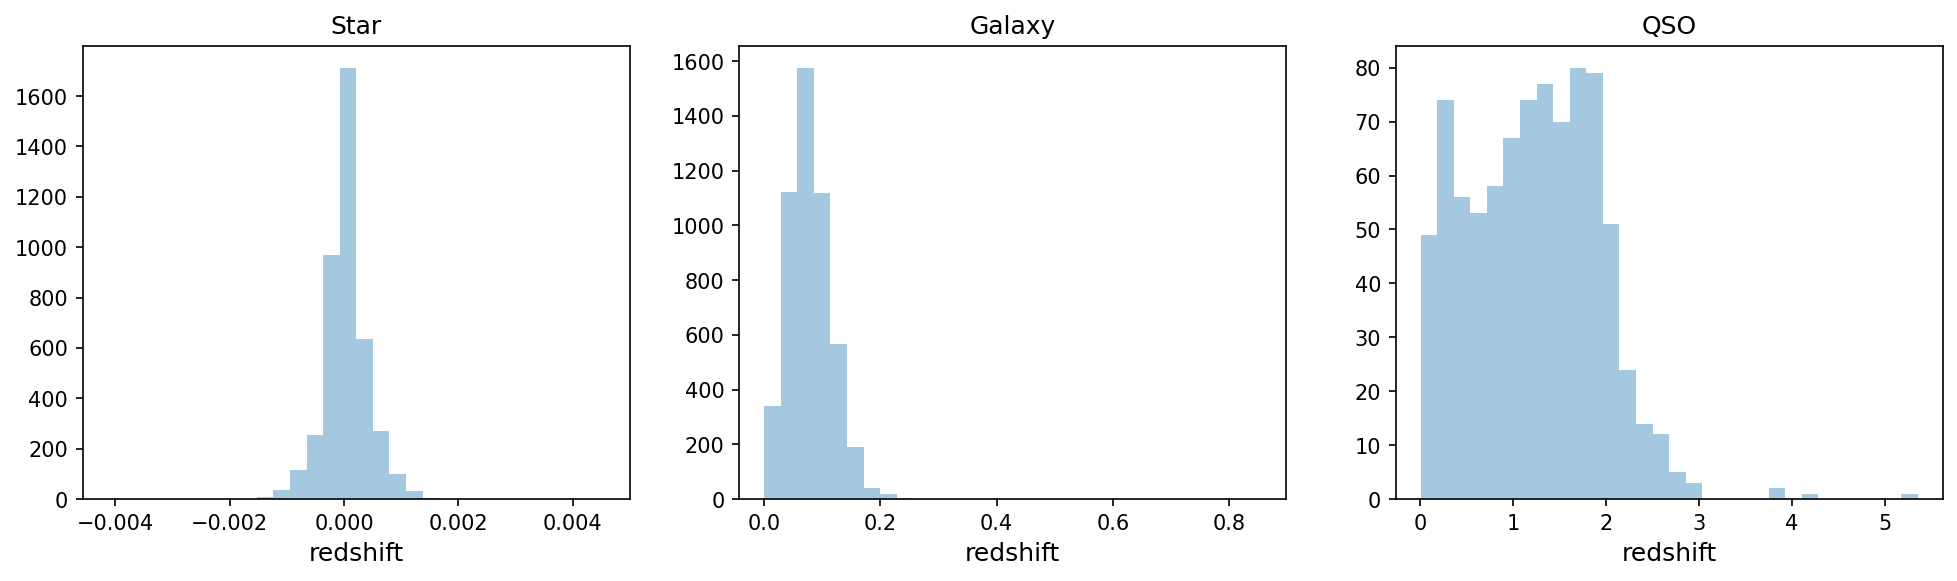

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
ax = sns.distplot(data[data['class']=='STAR'].redshift, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax = sns.distplot(data[data['class']=='GALAXY'].redshift, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax = sns.distplot(data[data['class']=='QSO'].redshift, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('QSO')

The redshift values for the classes quite different.

For Stars the histogram looks like a truncated zero-centered normal distribution.

For Galaxies the redshift values may come from a slightly right-shifted normal distribution which is centered around 0.075.

For Quasars the redshift values for QSOs are a lot more uniformly distributed than for Stars or Galaxies. They are roughly evenly distributed from 0 to 3, than the occurences decrease drastically.

The redshift is an estimate for the distance from the earth to a object.

Hence the distplot tells us that most of the stars observed are somewhat closer to the earth than galaxies or quasars. Galaxies tend to be a little further away and quasars are distant from very close to very far.

This particular feature redshift contribute more for classification.

Text(0.5, 1.0, 'dec')

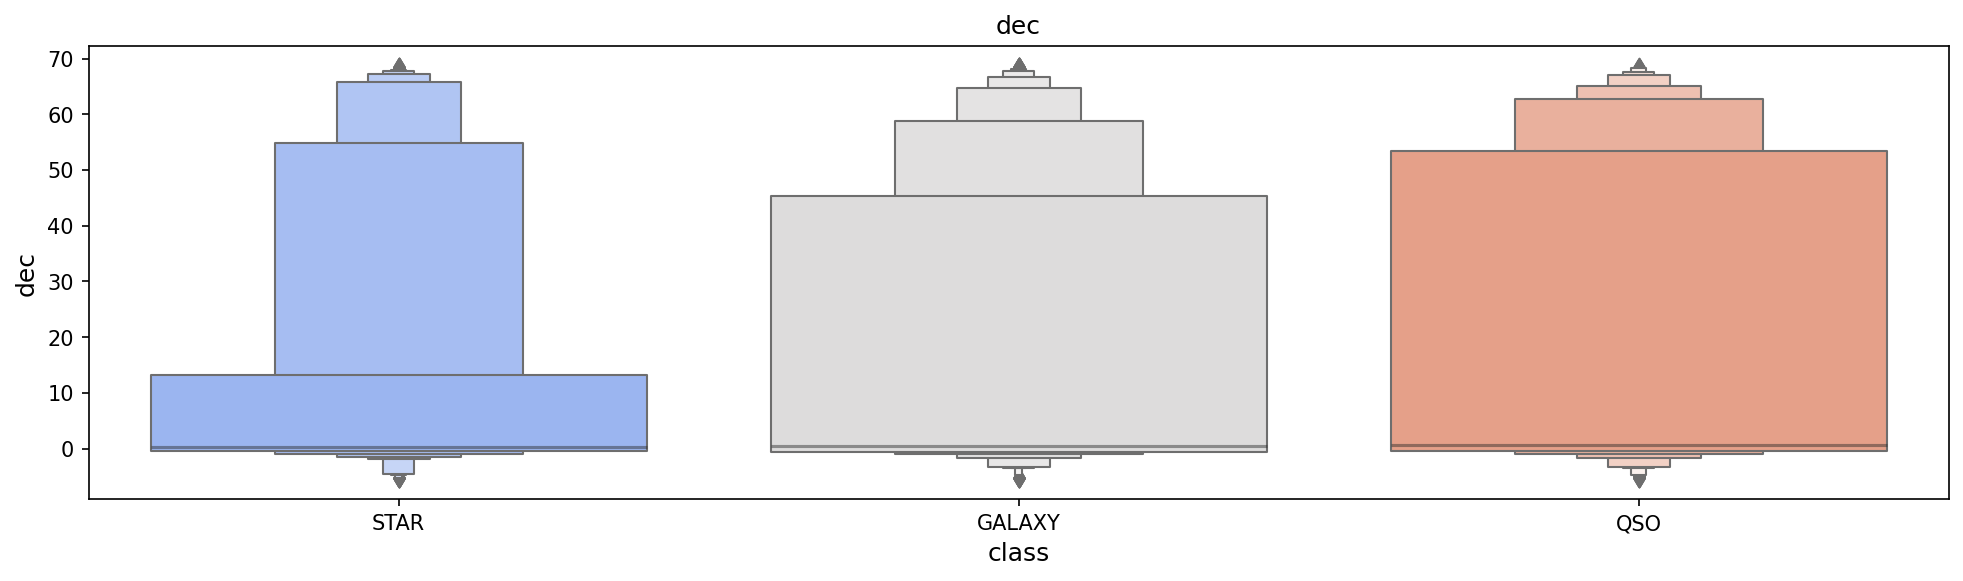

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(16, 4))
ax = sns.boxenplot(x=data['class'], y=data['dec'], palette='coolwarm')
ax.set_title('dec')

u, g, r, i, z represent the different wavelengths which are used to capture the observations.

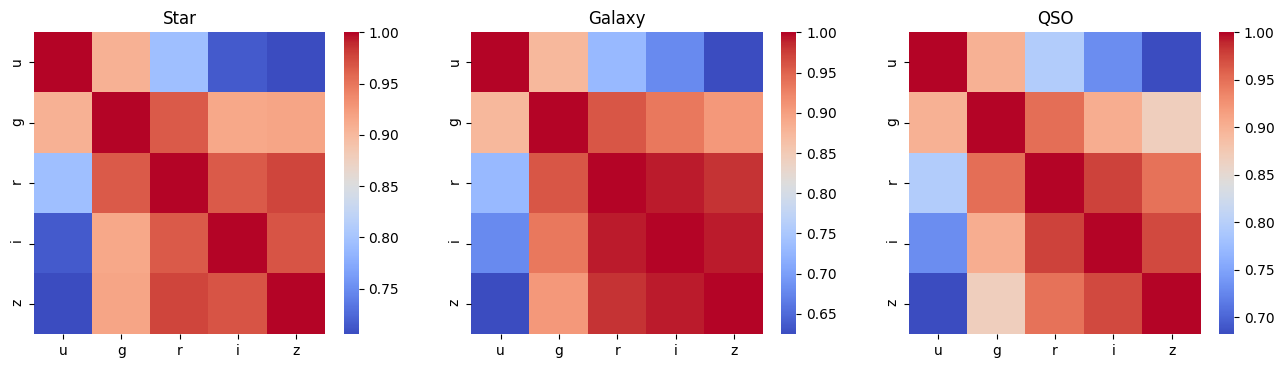

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
fig.set_dpi(100)
ax = sns.heatmap(data[data['class']=='STAR'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[0], cmap='coolwarm')
ax.set_title('Star')
ax = sns.heatmap(data[data['class']=='GALAXY'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[1], cmap='coolwarm')
ax.set_title('Galaxy')
ax = sns.heatmap(data[data['class']=='QSO'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[2], cmap='coolwarm')
ax = ax.set_title('QSO')

The heatmaps look similar but not identical, since only certain objects are observed at certain wavelengths of light.
As the features u, g, r, i, z all corresponds to wavelength of the light obsereved. So, PCA can be used to reduce these into
lower dimensions without loss of significant data.

In [11]:
le = LabelEncoder()
y_encoded = le.fit_transform(data['class'])
data['class'] = y_encoded
pca = PCA(n_components=3)
ugriz = pca.fit_transform(data[['u', 'g', 'r', 'i', 'z']])

# update dataframe
data = pd.concat((data, pd.DataFrame(ugriz)), axis=1)
data.rename({0: 'PCA_1', 1: 'PCA_2', 2: 'PCA_3'}, axis=1, inplace = True)
data.drop(['u', 'g', 'r', 'i', 'z'], axis=1, inplace=True)
data.head()
x = MinMaxScaler().fit_transform(data.drop('class', axis=1))
y = data[['class']]

Since quasars make up to only 10% of the total data, this imbalanced dataset which
result poor generalisation, so balancing this dataset will lead to better generalisation.

In [12]:
oversample = SMOTE()
x, y = oversample.fit_resample(x, y)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

In [13]:
#KNN
knn = KNeighborsClassifier()
training_start = time.perf_counter()
knn.fit(x_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
pred = knn.predict(x_test)
pred = pred.reshape(y_test.shape)
prediction_end = time.perf_counter()
acc_knn = (pred == y_test).sum().astype(float) / len(pred)*100
knn_train_time = training_end-training_start
knn_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's K Nearest Neighbors Classifier's prediction accuracy is: %3.2f" % acc_knn)
print("Time consumed for training: %4.3f seconds" % knn_train_time)
print("Time consumed for prediction: %6.5f seconds" % knn_prediction_time)

<ipython-input-13-9addf0c05190>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(x_train, y_train)


Scikit-Learn's K Nearest Neighbors Classifier's prediction accuracy is: 94.85
Time consumed for training: 0.065 seconds
Time consumed for prediction: 0.33697 seconds


In [14]:
#Guassina Naive Bayes
x = MaxAbsScaler().fit_transform(x)
x_train_gnb, x_test_gnb, y_train_gnb, y_test_gnb = train_test_split(x, y, test_size=0.33)

gnb = GaussianNB()
gnb = GaussianNB()
training_start = time.perf_counter()
gnb.fit(x_train_gnb, y_train_gnb)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
pred = gnb.predict(x_test_gnb)
prediction_end = time.perf_counter()
pred = pred.reshape(y_test.shape)
acc_gnb = (pred == y_test_gnb).sum().astype(float) / len(pred)*100
gnb_train_time = training_end-training_start
gnb_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: %3.2f" % acc_gnb)
print("Time consumed for training: %4.3f seconds" % gnb_train_time)
print("Time consumed for prediction: %6.5f seconds" % gnb_prediction_time)

Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: 97.37
Time consumed for training: 0.036 seconds
Time consumed for prediction: 0.00271 seconds


c:\users\sivat\pycharmprojects\xgb\venv\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [15]:
#XGBoost
xgb = XGBClassifier(n_estimators=100)
training_start = time.perf_counter()
xgb.fit(x_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
pred = xgb.predict(x_test)
prediction_end = time.perf_counter()
pred = pred.reshape(y_test.shape)
acc_xgb = (pred == y_test).sum().astype(float) / len(pred)*100
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start
print("XGBoost's prediction accuracy is: %3.2f" % acc_xgb)
print("Time consumed for training: %4.3f" % xgb_train_time)
print("Time consumed for prediction: %6.5f seconds" % xgb_prediction_time)

c:\users\sivat\pycharmprojects\xgb\venv\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


XGBoost's prediction accuracy is: 99.25
Time consumed for training: 1.508
Time consumed for prediction: 0.01711 seconds


In [16]:
rfc = RandomForestClassifier(n_estimators=10)
training_start = time.perf_counter()
rfc.fit(x_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
pred = rfc.predict(x_test)
prediction_end = time.perf_counter()
pred = pred.reshape(y_test.shape)
acc_rfc = (pred == y_test).sum().astype(float) / len(pred)*100
rfc_train_time = training_end-training_start
rfc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % acc_rfc)
print("Time consumed for training: %4.3f seconds" % rfc_train_time)
print("Time consumed for prediction: %6.5f seconds" % rfc_prediction_time)

<ipython-input-16-24f689651f22>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(x_train, y_train)


Scikit-Learn's Random Forest Classifier's prediction accuracy is: 99.07
Time consumed for training: 0.271 seconds
Time consumed for prediction: 0.00762 seconds


In [17]:
svc = SVC()
training_start = time.perf_counter()
svc.fit(x_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
pred = svc.predict(x_test)
prediction_end = time.perf_counter()
pred = pred.reshape(y_test.shape)
acc_svc = (pred == y_test).sum().astype(float) / len(pred)*100
svc_train_time = training_end-training_start
svc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: %3.2f" % acc_svc)
print("Time consumed for training: %4.3f seconds" % svc_train_time)
print("Time consumed for prediction: %6.5f seconds" % svc_prediction_time)

c:\users\sivat\pycharmprojects\xgb\venv\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: 95.88
Time consumed for training: 0.883 seconds
Time consumed for prediction: 0.29023 seconds


In [18]:
results = pd.DataFrame({
    'Model': ['KNN', 'Naive Bayes',
              'XGBoost', 'Random Forest', 'SVC'],
    'Score': [float(acc_knn), float(acc_gnb), float(acc_xgb), float(acc_rfc), float(acc_svc)],
    'Runtime Training': [knn_train_time, gnb_train_time, xgb_train_time, rfc_train_time,
                         svc_train_time],
    'Runtime Prediction': [knn_prediction_time, gnb_prediction_time, xgb_prediction_time, rfc_prediction_time,
                          svc_prediction_time]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.reset_index(drop=True)
result_df

,Model,Score,Runtime Training,Runtime Prediction
0,XGBoost,99.252374,1.507785,0.017107
1,Random Forest,99.070519,0.270587,0.007619
2,Naive Bayes,97.373207,0.035903,0.002715
3,SVC,95.877955,0.882786,0.290232
4,KNN,94.847444,0.065469,0.336968


In [19]:
importance = pd.DataFrame({
    'Feature': data.drop('class', axis=1).columns,
    'Importance': xgb.feature_importances_
})
importance = importance.sort_values(by='Importance', ascending=False)
importance

,Feature,Importance
2,redshift,0.706970
7,PCA_2,0.200411
8,PCA_3,0.039454
6,PCA_1,0.024141
0,ra,0.006957
3,plate,0.006923
5,fiberid,0.005862
1,dec,0.005317
4,mjd,0.003965


<AxesSubplot:>

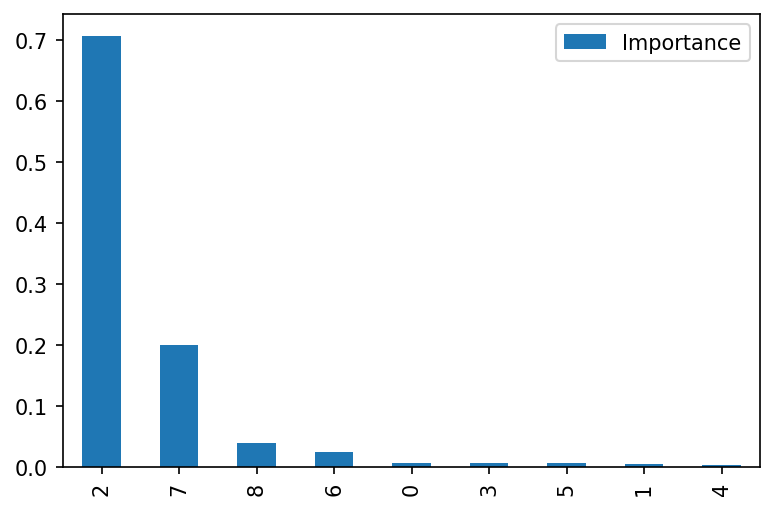

In [20]:
importance.plot.bar()

In [33]:
#Hyperparamters tuning for XGBoost.
param_test1 = {
 'max_depth':range(3,10,1),
 'min_child_weight':range(1,6,1)
}
gsearch_1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,nthread=4, scale_pos_weight=1, seed=27),
 param_grid = param_test1, scoring='accuracy',n_jobs=4,iid=False, cv=5)
gsearch_1.fit(x_train,y_train)
gsearch_1.best_params_, gsearch_1.best_score_

c:\users\sivat\pycharmprojects\xgb\venv\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


[14:56:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




({'max_depth': 5, 'min_child_weight': 1}, 0.9942994997498749)

In [34]:
param_test1 = {
 'max_depth':[4, 5, 6],
 'min_child_weight':[1, 2, 3]
}
gsearch_1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,nthread=4, scale_pos_weight=1, seed=27),
 param_grid = param_test1, scoring='accuracy',n_jobs=4,iid=False, cv=5)
gsearch_1.fit(x_train,y_train)
gsearch_1.best_params_, gsearch_1.best_score_

c:\users\sivat\pycharmprojects\xgb\venv\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


[14:57:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




({'max_depth': 5, 'min_child_weight': 1}, 0.9942994997498749)

In [36]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch_3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 nthread=4, scale_pos_weight=1,seed=27),
 param_grid = param_test3, scoring='accuracy',n_jobs=4,iid=False, cv=5)
gsearch_3.fit(x_train,y_train)
gsearch_3.best_params_, gsearch_3.best_score_

c:\users\sivat\pycharmprojects\xgb\venv\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


[14:59:07] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




({'gamma': 0.0}, 0.9942994997498749)

The best parameters for prediction as found by the tuning tests are:

* max_depth = 5
* min_child_weight = 1
* gamma = 0
* subsample = 0.8
* colsample_bytree = 0.8
* reg_alpha = 0.005

In [29]:
x_train, x_test, y_train, y_test = train_test_split(data.drop('class', axis=1), data['class'],
                                                   test_size=0.33)

In [41]:
xgboost = XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=140, gamma=0,
                        min_child_weight=1, subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=1,seed=27)
xgboost.fit(x_train, y_train)
pred = xgboost.predict(x_test)
pred = pred.reshape(y_test.shape)
accuracy = (pred == y_test).sum().astype(float) / len(pred)*100

print("XGBoost's prediction accuracy WITH optimal hyperparameters is: %3.2f" % accuracy)

[15:06:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


XGBoost's prediction accuracy WITH optimal hyperparameters is: 99.27
